# Test plane extraction for a single point cloud

In [2]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import time
import open3d as o3d

import planeslam.general as general
from planeslam.mesh import LidarMesh
from planeslam.scan import Scan
from planeslam.clustering import cluster_mesh_graph_search, mesh_cluster_pts
from planeslam.extraction import scan_from_clusters

%load_ext autoreload
%autoreload 2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Read Point Cloud from pcd file

In [9]:
# Read in point cloud data
pcfile = os.path.join(os.getcwd(),'..', 'data', 'airsim', 'blocks_0.pcd')
pcd = o3d.io.read_point_cloud(pcfile)
P = np.asarray(pcd.points)

In [10]:
# Convert points to ENU
P = general.NED_to_ENU(P)

# Downsample the points
P = general.downsample(P, factor=5, axis=0)

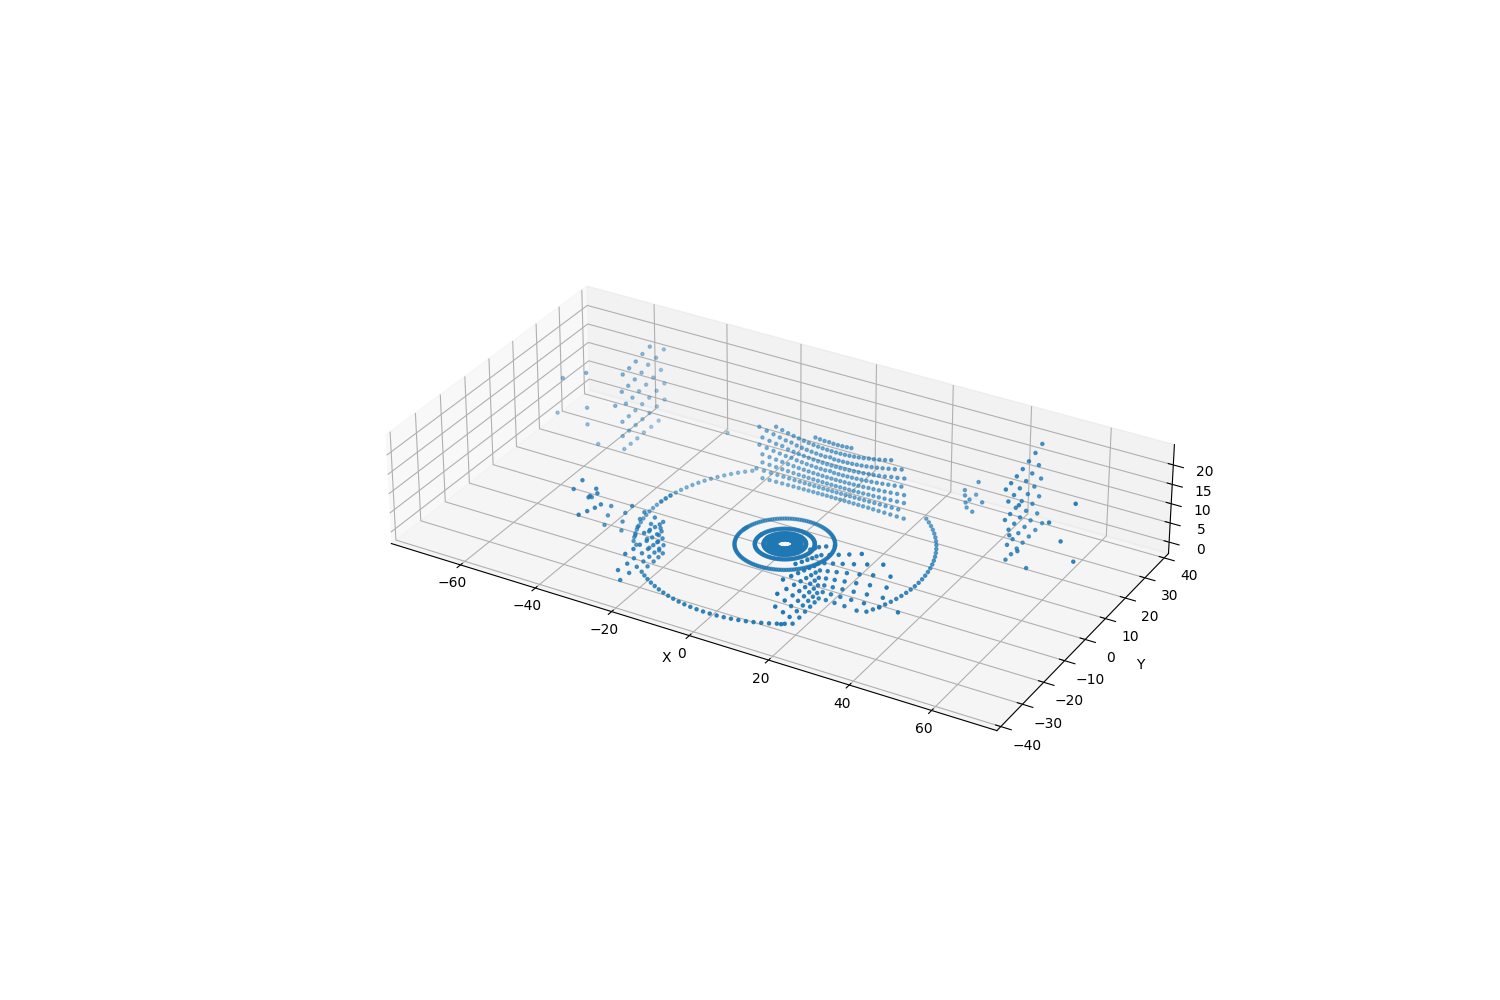

In [12]:
# Plot the points
ax = general.plot_3D_setup(P)
ax.scatter3D(P[:,0], P[:,1], P[:,2], marker='.')  

Cluster the points

In [13]:
# Create the mesh
mesh = LidarMesh(P)
mesh.prune(10)
start_time = time.time()
# Cluster the mesh with graph search
clusters, avg_normals = cluster_mesh_graph_search(mesh)
print("elapsed time: ", time.time() - start_time)

elapsed time:  0.19505739212036133


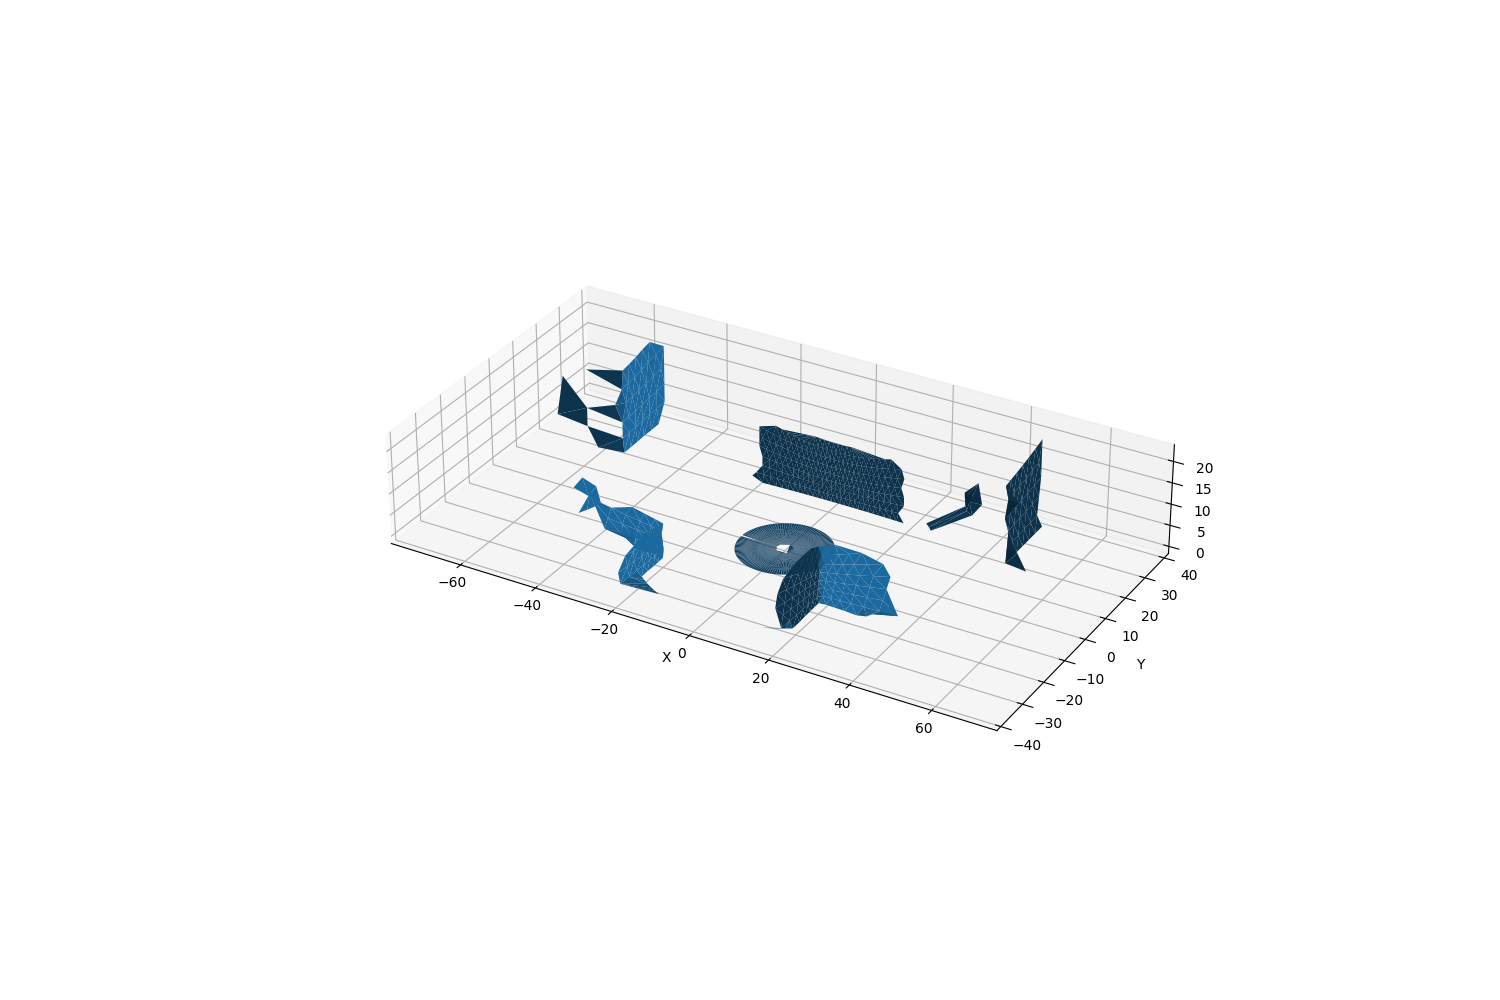

In [14]:
# Plot mesh
ax = general.plot_3D_setup(P)

ax.plot_trisurf(P[:,0], P[:,1], P[:,2], triangles=mesh.DT.simplices)

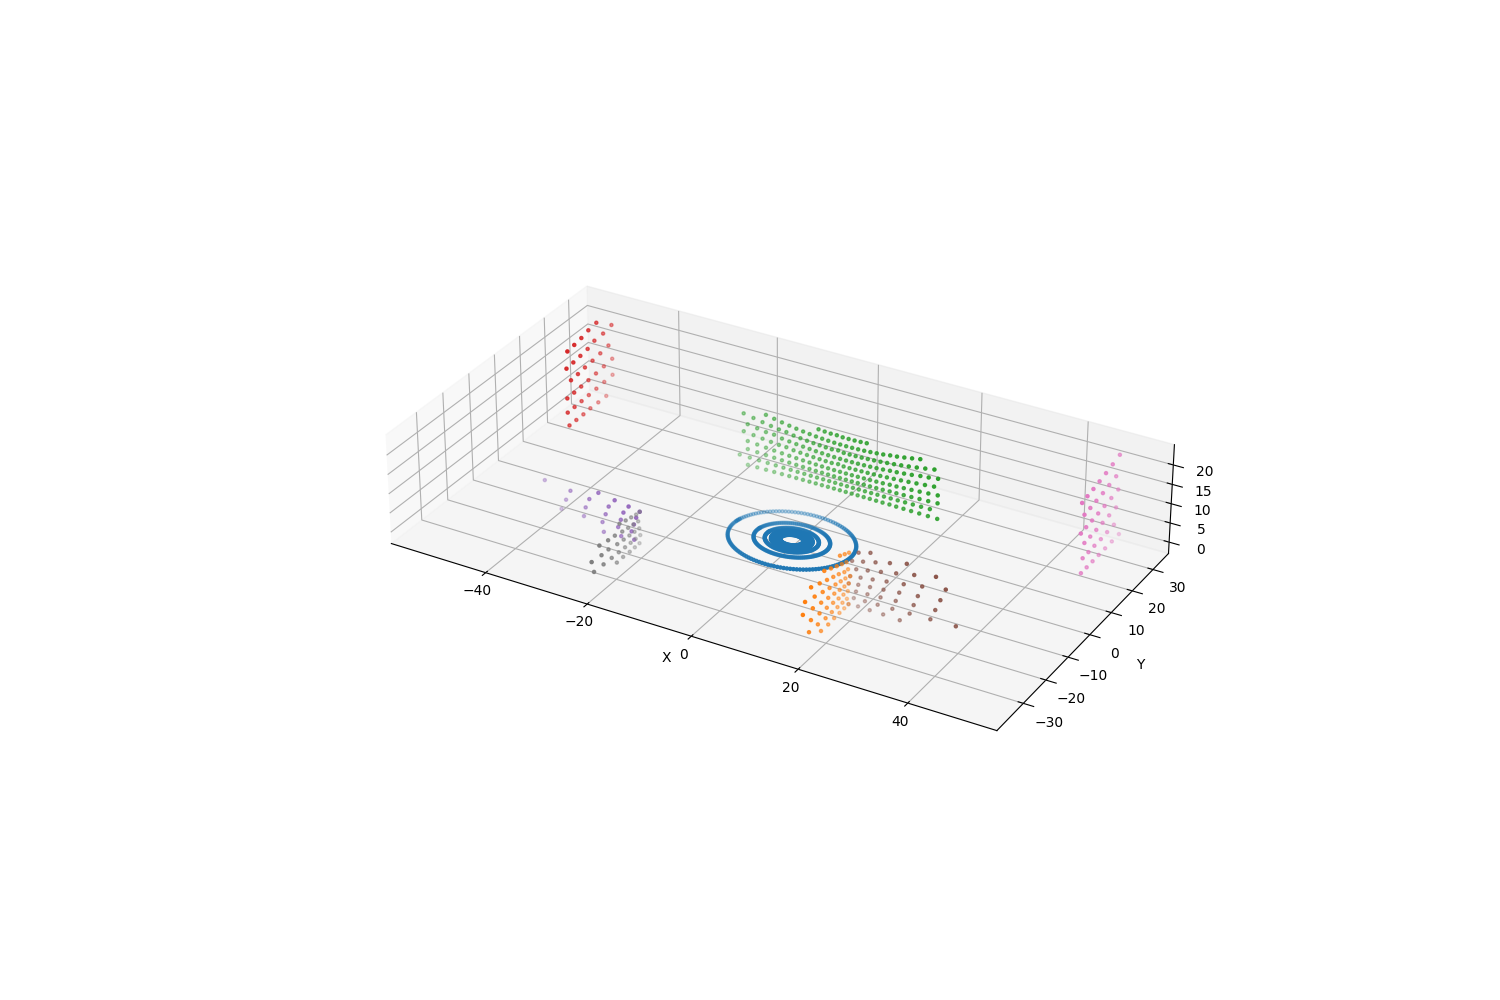

In [15]:
# Plot clusters
ax = general.plot_3D_setup(P)

cmap = cm.get_cmap('plasma')
cmap_idxs = int(len(cmap.colors) / len(clusters)) * np.arange(len(clusters))
colors = np.asarray(cmap.colors)[cmap_idxs,:]

for i, c in enumerate(clusters):
    cluster_pts = mesh_cluster_pts(mesh, c)
    ax.scatter3D(cluster_pts[:,0], cluster_pts[:,1], cluster_pts[:,2], color='C'+str(i), marker='.')  

    # Show normals
    # c = np.mean(cluster_pts, axis=0)
    # n = 10 * avg_normals[i]
    # ax.quiver(c[0], c[1], c[2], n[0], n[1], n[2])

Extract planes

In [16]:
planes, vertices, faces = scan_from_clusters(mesh, clusters, avg_normals)
scan = Scan(planes, vertices, faces)

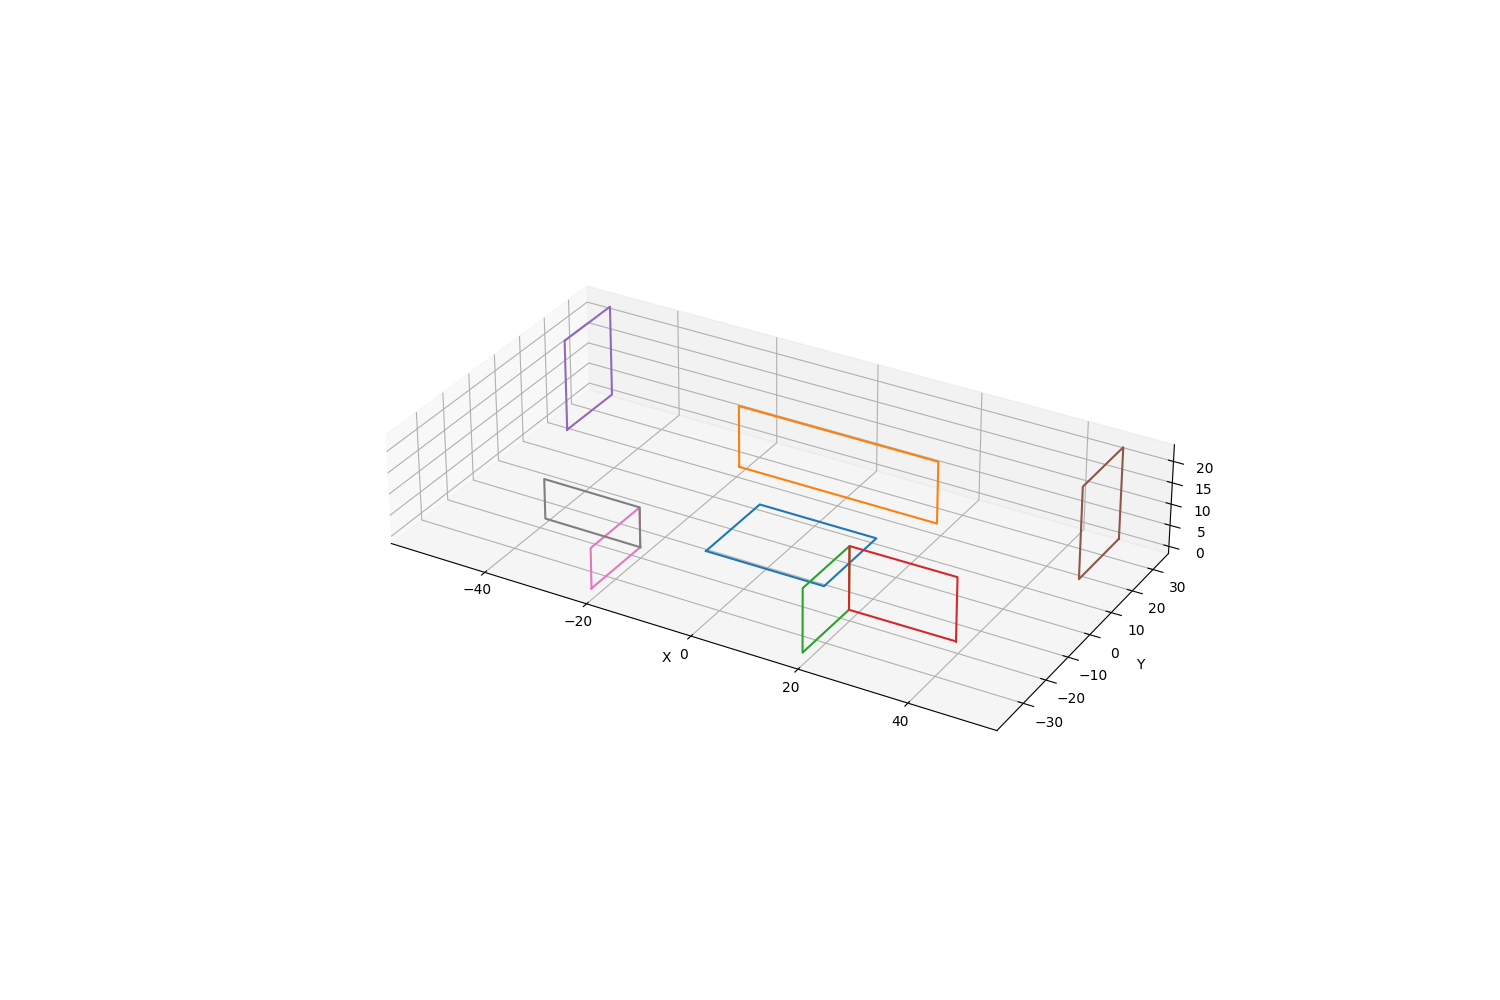

In [17]:
ax = general.plot_3D_setup(P)
scan.plot(ax, show_normals=False)